In [19]:
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Local modules
import modularised_utils as mut
import opt_utils as oput 
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import params
import random

from math_utils import compute_wasserstein

In [49]:
experiment = 'lucas6x3'

In [50]:
T_results = joblib.load(f"data/{experiment}/diroca_train_results.pkl")

In [51]:
#abduction       = False
coeff_estimation = False

# Define the number of samples per environment. Currently every environment has the same number of samples
if experiment == 'synth1' or experiment == 'synth1.1' or experiment == 'synth1.2':
    num_llsamples, num_hlsamples  = params.n_samples['synth1']
if experiment == 'lucas6x3' or experiment == 'lucas6x3.1' or experiment == 'lucas6x3.2' or experiment == 'lucas6x3.3':
    num_llsamples, num_hlsamples  = params.n_samples['lucas6x3']

Dll_obs, Dhl_obs  = mut.load_samples(experiment)[None][0], mut.load_samples(experiment)[None][1] 

Gll, Ill = mut.load_model(experiment, 'LL')
Ghl, Ihl = mut.load_model(experiment, 'HL')

n_varsll, n_varshl = len(Gll.nodes()), len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
# if abduction == True:
#     U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
#     U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
# else:
#     U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
#     U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels = {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [52]:
# Load data
#data = mut.load_samples(experiment)

# Generate data
data = evut.generate_data(LLmodels, HLmodels, omega, num_llsamples, num_hlsamples, mu_U_ll_hat, Sigma_U_ll_hat, mu_U_hl_hat, Sigma_U_hl_hat)

In [53]:
test_observ        = True 
test_interv        = True
num_iter           = 100
metric             = 'wass'


In [54]:
if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

### test theorem

requires coeff_estimation = True

In [55]:
results_single = {method: {'errors': [], 'mean': 0, 'ci': 0} for method in T_results.keys()}

for name, res in T_results.items():
    T = res['T_matrix']
    errors = []  # Store errors for each intervention
    scale_factor = 1/np.sqrt(len(Ill))
    wass_total = 0
    for iota in Ill:
        L_i = LLmodels[iota].F
        V_i = T @ L_i
        H_i = HLmodels[omega[iota]].F
        
        muV    = V_i @ mu_U_ll_hat
        sigmaV = V_i @ Sigma_U_ll_hat @ V_i.T
        muH    = H_i @ mu_U_hl_hat
        sigmaH = H_i @ Sigma_U_hl_hat @ H_i.T


        # Compute Wasserstein metric
        wass_dist = np.sqrt(mut.compute_wasserstein(muV, sigmaV, muH, sigmaH))
        errors.append(wass_dist)
        wass_total += wass_dist

     # Calculate mean and CI
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    ci = 1.96 * std_error

    # Store all statistics
    results_single[name] = {
        'errors': errors,
        'mean': mean_error,
        'ci': ci
    }

results_single = dict(sorted(results_single.items(), key=lambda x: x[1]['mean']))

# Print results
print("\n" + "="*100)
print(f"{'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for method, stats in results_single.items():
    print(f"{method:<15} {stats['mean']:>8.4f} ± {stats['ci']:<8.4f}")



Method          Error (mean ± CI)                  
T_0.031           2.3452 ± 2.6002  
T_1               3.6526 ± 2.0096  
T_2               4.5597 ± 1.1946  
T_b               4.6097 ± 4.1859  
T_0.00            5.0644 ± 2.2819  
T_4               6.5086 ± 1.7010  
T_8               7.1346 ± 0.8113  
T_s               8.4577 ± 1.7232  
T_ba             10.7258 ± 2.3238  


In [107]:
rad_values = np.arange(0.05, 100.05, 10).tolist()  
sample_forms = ['boundary', 'sample']

center = 'worst'

coverage = 'uniform'

In [108]:
hat_dict = {'L': [mu_U_ll_hat, Sigma_U_ll_hat], 'H': [mu_U_hl_hat, Sigma_U_hl_hat]}

worst = 'T_2'
mu_worst_L    = T_results[worst]['optimization_params']['L']['mu_U']
Sigma_worst_L = T_results[worst]['optimization_params']['L']['Sigma_U']
mu_worst_H    = T_results[worst]['optimization_params']['H']['mu_U']
Sigma_worst_H = T_results[worst]['optimization_params']['H']['Sigma_U']

worst_dict = {'L': [mu_worst_L, Sigma_worst_L], 'H': [mu_worst_H, Sigma_worst_H]}


In [109]:
results = {rad: {
    sample_form: {  # This is correct - using the variable
        'wass': {method: [] for method in T_results.keys()}
    } for sample_form in sample_forms
} for rad in rad_values}


for rad in tqdm(rad_values):
   for sample_form in sample_forms:
       for _ in range(5):

           noise_muL, noise_SigmaL = mut.noise_generation(center=center, radius=rad,
                   sample_form=sample_form, level='L', hat_dict=hat_dict, worst_dict=worst_dict, coverage=coverage, normalize=False)
           noise_muH, noise_SigmaH = mut.noise_generation(center=center, radius=rad,
                   sample_form=sample_form, level='H', hat_dict=hat_dict, worst_dict=worst_dict, coverage=coverage, normalize=False)
          
           noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
           noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
           noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
           noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

    
           for name, res in T_results.items():
               T = res['T_matrix']
               wass_total = 0
               for iota in Ill:
                   L_i = LLmodels[iota].F
                   V_i = T @ L_i
                   H_i = HLmodels[omega[iota]].F
                  
                   muV    = V_i @ noise_muL
                   sigmaV = V_i @ noise_SigmaL @ V_i.T
                   muH    = H_i @ noise_muH
                   sigmaH = H_i @ noise_SigmaH @ H_i.T


                   # Compute Wasserstein metric
                   wass_dist = np.sqrt(mut.compute_wasserstein(muV, sigmaV, muH, sigmaH))
                   wass_total += wass_dist


               # Store results
               results[rad][sample_form]['wass'][name].append(wass_total / len(Ill))


print("\n" + "="*100)
print(f"{'Radius':<8} {'Method':<15} {'Wasserstein (mean ± CI)':<35}")
print("="*100)


for rad in rad_values:
   for sample_form in sample_forms:
       print(f"\nSample form: {sample_form}")
       print("-"*100)
      
       for method in T_results.keys():
           # Compute statistics for Wasserstein metric
           wass_mean = np.mean(results[rad][sample_form]['wass'][method])
           wass_std = np.std(results[rad][sample_form]['wass'][method])
          
           # Print row
           print(f"{rad:<8} {method:<15} "
                 f"{wass_mean:>8.4f} ± {1.96*wass_std:<8.4f}")


print("="*100)


# Find best methods for Wasserstein metric
for rad in rad_values:
   for sample_form in sample_forms:
       print(f"\nBest methods for radius {rad}, {sample_form} sampling:")
      
       # For Wasserstein
       wass_means = {method: np.mean(results[rad][sample_form]['wass'][method])
                    for method in T_results.keys()}
       best_wass = min(wass_means.items(), key=lambda x: x[1])
      
       print(f"Best Wasserstein: {best_wass[0]} ({best_wass[1]:.4f})")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Radius   Method          Wasserstein (mean ± CI)            

Sample form: boundary
----------------------------------------------------------------------------------------------------
0.05     T_8               4.8869 ± 0.0126  
0.05     T_0.031           4.3869 ± 0.0371  
0.05     T_1               3.0856 ± 0.0269  
0.05     T_2               1.5856 ± 0.0433  
0.05     T_4               4.1932 ± 0.0061  
0.05     T_0.00            4.7980 ± 0.0776  
0.05     T_b               5.6895 ± 0.0235  
0.05     T_ba              8.1702 ± 0.0085  
0.05     T_s               6.0395 ± 0.0150  

Sample form: sample
----------------------------------------------------------------------------------------------------
0.05     T_8               4.9013 ± 0.0035  
0.05     T_0.031           4.4472 ± 0.0135  
0.05     T_1               3.1119 ± 0.0083  
0.05     T_2               1.5859 ± 0.0100  
0.05     T_4               4.2103 ± 0.0052  
0.05     T_0.00            4.8529 ± 0.0186  
0.05     T_b     

In [110]:
def plot_abstraction_error(results, methods, sample_form, figsize=(12, 8)):
    """
    Plot abstraction error vs radius for specified methods and sample form.
    
    Parameters:
    -----------
    results : dict
        The results dictionary containing the data
    methods : list
        List of method names to plot
    sample_form : str
        Either 'boundary' or 'sample'
    figsize : tuple
        Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Define method styles
    method_styles = {
        'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
        'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
        'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
        'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
    }
    
    # Add styles for trained T matrices using different markers and blues
    blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
    markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
    for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
        method_name = f'T_{eps}'
        method_styles[method_name] = {
            'color': blues[i],
            'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
            'marker': markers[i]
        }
    
    # Extract radius values and sort them
    radius_values = sorted([float(r) for r in results.keys()])
    
    # Plot each method
    for method in methods:
        if method not in method_styles:
            print(f"Warning: No style defined for method {method}")
            continue
            
        style = method_styles[method]
        errors = []
        
        # Collect data for each radius
        for rad in radius_values:
            # Get the list of values for this method at this radius
            values = results[rad][sample_form]['wass'][method]
            # Compute mean
            mean = np.mean(values)
            errors.append(mean)
        
        # Plot without error bars
        plt.plot(radius_values, errors,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                alpha=0.8,
                markersize=12,
                linewidth=2)
    
    # Customize plot
    plt.xlabel(r'Radius ($\varepsilon_{\ell}=\varepsilon_{h}$)', fontsize=30)
    plt.ylabel('Abstraction Error', fontsize=30)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    # Add legend
    plt.legend(prop={'size': 24},
              frameon=True,
              framealpha=1,
              borderpad=0.5,
              handletextpad=0.5,
              handlelength=1.5,
              ncol=2,
              loc='best')
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show plot
    plt.show()

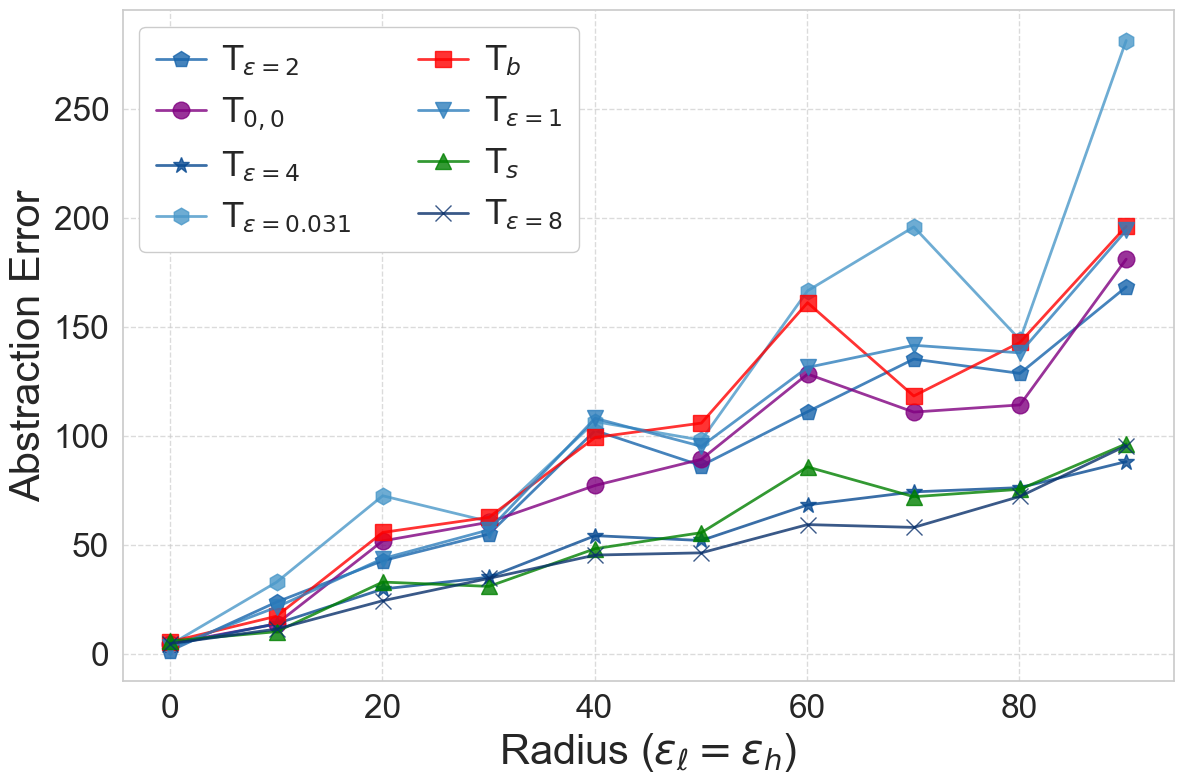

In [111]:
# Example usage:
#methods_to_plot = list(T_results.keys())-['T_0.00']
methods_to_plot = list(set(T_results.keys()) - {'T_ba'})
plot_abstraction_error(results, methods_to_plot, 'boundary')
#plot_abstraction_error(results, methods_to_plot, 'sample')

### Shifted gaussians

In [32]:
def generate_shifted_gaussian_family(mu, Sigma, k, r_mu=1.0, r_sigma=1.0, seed=None):
    """
    Generate k shifted multivariate Gaussians from a base Gaussian N(mu, Sigma).

    Args:
        mu: Base mean vector (d,)
        Sigma: Base covariance matrix (d, d)
        k: Number of shifted distributions
        r_mu: Max norm of mean shifts
        r_sigma: Max Frobenius norm of covariance shifts
        seed: Optional random seed

    Returns:
        List of (mu_i, Sigma_i) tuples
    """
    if seed is not None:
        np.random.seed(seed)

    d = mu.shape[0]
    shifted = []

    for _ in range(k):
        # Mean shift: random direction, scaled to r_mu
        delta_mu = np.random.randn(d)
        delta_mu = r_mu * delta_mu / np.linalg.norm(delta_mu)

        # Covariance shift: random symmetric matrix with Frobenius norm = r_sigma
        A = np.random.randn(d, d)
        sym_A = (A + A.T) / 2
        delta_Sigma = r_sigma * sym_A / np.linalg.norm(sym_A, ord='fro')

        mu_i = mu + delta_mu
        Sigma_i = Sigma + delta_Sigma

        # Ensure positive semi-definite by projecting (optional)
        eigvals, eigvecs = np.linalg.eigh(Sigma_i)
        Sigma_i = eigvecs @ np.diag(np.clip(eigvals, 1e-4, None)) @ eigvecs.T

        shifted.append((mu_i, Sigma_i))

    return shifted

In [33]:
coverage_type = 'uniform'
center = 'worst'
worst = 'T_8'

In [34]:
mu_worst_L    = T_results[worst]['optimization_params']['L']['mu_U']
Sigma_worst_L = T_results[worst]['optimization_params']['L']['Sigma_U']
mu_worst_H    = T_results[worst]['optimization_params']['H']['mu_U']
Sigma_worst_H = T_results[worst]['optimization_params']['H']['Sigma_U']

In [35]:
if center == 'worst':
    shift_family_L = mut.generate_shifted_gaussian_family(mu_worst_L, Sigma_worst_L, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
    shift_family_H = mut.generate_shifted_gaussian_family(mu_worst_H, Sigma_worst_H, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
elif center == 'hat':
    shift_family_L = mut.generate_shifted_gaussian_family(mu_U_ll_hat, Sigma_U_ll_hat, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
    shift_family_H = mut.generate_shifted_gaussian_family(mu_U_hl_hat, Sigma_U_hl_hat, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)

In [36]:
# shift_family_L = generate_shifted_gaussian_family(mu_worst_L, Sigma_worst_L, 10, r_mu=1.0, r_sigma=1.0, seed=None)
# shift_family_H = generate_shifted_gaussian_family(mu_worst_H, Sigma_worst_H, 10, r_mu=1.0, r_sigma=1.0, seed=None)

In [37]:
for center in ['worst', 'hat']:
    for coverage_type in ['uniform']:
        print(f"Center: {center}, Coverage: {coverage_type}")
        if center == 'worst':
            shift_family_L = mut.generate_shifted_gaussian_family(mu_worst_L, Sigma_worst_L, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
            shift_family_H = mut.generate_shifted_gaussian_family(mu_worst_H, Sigma_worst_H, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
        elif center == 'hat':
            shift_family_L = mut.generate_shifted_gaussian_family(mu_U_ll_hat, Sigma_U_ll_hat, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
            shift_family_H = mut.generate_shifted_gaussian_family(mu_U_hl_hat, Sigma_U_hl_hat, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)

        results = {
            sample_form: {  # This is correct - using the variable
                'wass': {method: [] for method in T_results.keys()}
            } for sample_form in sample_forms
        }

        for shift_L, shift_H in zip(shift_family_L, shift_family_H):
            for sample_form in sample_forms:
            
                # Use the shifted means and covariances directly
                noise_muL, noise_SigmaL = shift_L
                noise_muH, noise_SigmaH = shift_H
                
                
                # Convert to numpy if they're tensors
                noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
                noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
                noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
                noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

                for name, res in T_results.items():
                    T = res['T_matrix']
                    wass_total = 0
                    for iota in Ill:
                        L_i = LLmodels[iota].F
                        V_i = T @ L_i
                        H_i = HLmodels[omega[iota]].F
                        
                        muV    = V_i @ noise_muL
                        sigmaV = V_i @ noise_SigmaL @ V_i.T
                        muH    = H_i @ noise_muH
                        sigmaH = H_i @ noise_SigmaH @ H_i.T

                        # Compute Wasserstein metric
                        wass_dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                        wass_total += wass_dist

                    # Store results
                    results[sample_form]['wass'][name].append(wass_total / len(Ill))

        print("\n" + "="*100)
        print(f"{'Method':<15} {'Wasserstein (mean ± CI)':<35}")
        print("="*100)

        for sample_form in sample_forms:
            print(f"\nSample form: {sample_form}")
            print("-"*100)
            
            # Create a list of (method, mean, std) tuples and sort by mean (worst to best)
            method_stats = []
            for method in T_results.keys():
                wass_mean = np.mean(results[sample_form]['wass'][method])
                wass_std = np.std(results[sample_form]['wass'][method])
                method_stats.append((method, wass_mean, wass_std))
            
            # Sort by mean value (descending order - worst to best)
            method_stats.sort(key=lambda x: x[1], reverse=True)
            
            # Print sorted results
            for method, wass_mean, wass_std in method_stats:
                print(f"{method:<15} "
                    f"{wass_mean:>8.4f} ± {1.96*wass_std:<8.4f}")

        print("="*100)

        # Find best methods for Wasserstein metric
        for sample_form in sample_forms:
            print(f"\nBest methods for {sample_form} sampling:")
            
            # For Wasserstein
            wass_means = {method: np.mean(results[sample_form]['wass'][method])
                        for method in T_results.keys()}
            best_wass = min(wass_means.items(), key=lambda x: x[1])
            
            print(f"Best Wasserstein: {best_wass[0]} ({best_wass[1]:.4f})")
        print( )

Center: worst, Coverage: uniform

Method          Wasserstein (mean ± CI)            

Sample form: boundary
----------------------------------------------------------------------------------------------------
T_0.031           4.1076 ± 0.5098  
T_0.00            3.7323 ± 0.4393  
T_b               3.4457 ± 0.3817  
T_ba              2.5246 ± 0.1846  
T_s               2.4777 ± 0.1890  
T_1               2.3158 ± 0.2756  
T_8               1.6653 ± 0.3561  
T_4               1.6653 ± 0.3561  
T_2               1.5792 ± 0.4776  

Sample form: sample
----------------------------------------------------------------------------------------------------
T_0.031           4.1076 ± 0.5098  
T_0.00            3.7323 ± 0.4393  
T_b               3.4457 ± 0.3817  
T_ba              2.5246 ± 0.1846  
T_s               2.4777 ± 0.1890  
T_1               2.3158 ± 0.2756  
T_8               1.6653 ± 0.3561  
T_4               1.6653 ± 0.3561  
T_2               1.5792 ± 0.4776  

Best methods for bo

## F-contamination

In [38]:
def contaminate_structural_matrix(M, contamination_fraction, contamination_type, num_segments=10, seed=None):
   """
   Contaminates a linear transformation matrix M to break its strict linearity.
  
   Args:
       M (np.ndarray): Original linear transformation matrix (n x m).
       contamination_fraction (float): Magnitude of contamination (e.g., between 0.05 and 1.0).
       contamination_type (str): Type of contamination to apply. Options are:
                                 'multiplicative', 'nonlinear', or 'piecewise'.
       num_segments (int): Number of segments for piecewise linear contamination (default: 3).
       seed (int, optional): Random seed for reproducibility.
      
   Returns:
       np.ndarray: The contaminated matrix.
   """
   rng = np.random.default_rng(seed)
   M_cont = M.copy() 
   n, m = M.shape


   if contamination_type == "multiplicative":
       # Apply element-wise multiplicative noise (preserving zeros below the main diagonal)
       # Only perturb the upper-triangular part.
       noise = rng.uniform(low=1.0 - contamination_fraction, high=1.0 + contamination_fraction, size=M.shape)
       # Create a mask for the upper triangular (including diagonal)
       mask = np.triu(np.ones_like(M))
       M_cont = M * (1 - mask + mask * noise)
  
   elif contamination_type == "nonlinear":
       # Apply a nonlinear function to L: for instance, add a sine-based perturbation.
       M_cont = M + contamination_fraction * np.sin(M)
  
   elif contamination_type == "piecewise":
       # Contaminate each row with a piecewise linear function.
       def piecewise_contaminate_row(row, cont_frac, segments, rng):
           n_elem = len(row)
           # Choose random breakpoints among indices
           if segments < 2:
               return row  # nothing to do
           breakpoints = np.sort(rng.integers(low=1, high=n_elem, size=segments - 1))
           breakpoints = np.concatenate(([0], breakpoints, [n_elem]))
           contaminated_row = np.empty_like(row)
           # For each segment, assign a random multiplicative factor.
           for j in range(len(breakpoints) - 1):
               start = breakpoints[j]
               end = breakpoints[j+1]
               factor = 1.0 + rng.uniform(low=-cont_frac, high=cont_frac)
               contaminated_row[start:end] = row[start:end] * factor
           return contaminated_row
      
       # Apply the piecewise contamination row-by-row.
       for i in range(n):
           M_cont[i, :] = piecewise_contaminate_row(M[i, :], contamination_fraction, num_segments, rng)
  
   else:
       raise ValueError("Unknown contamination type. Choose among 'multiplicative', 'nonlinear', or 'piecewise'.")
  
   return M_cont


In [113]:
def plot_contamination_results(plot_results, contamination_levels, cont_type, methods_to_plot=None):
    """
    Plot the results of contamination analysis for selected methods.
    
    Args:
        plot_results: Dictionary containing means and stds for each method
        contamination_levels: Array of contamination levels tested
        cont_type: Type of contamination applied
        methods_to_plot: List of method names to plot. If None, plots all methods
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: plot_results[method] 
                      for method in methods_to_plot 
                      if method in plot_results}
    
    # Define base method styles
    method_styles = {
        'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
        'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
        'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
        'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
    }
    
    # Add styles for trained T matrices using different markers and blues
    blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
    markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
    for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
        method_name = f'T_{eps}'
        method_styles[method_name] = {
            'color': blues[i],
            'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
            'marker': markers[i]
        }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(contamination_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=8,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(contamination_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Contamination Level', fontsize=16)
    plt.ylabel('Abstraction Error', fontsize=16)
    plt.title(f'Abstraction Error vs Contamination Level\n({cont_type} contamination)',
             fontsize=16, pad=20)
    
    plt.xticks(contamination_levels, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add legend
    plt.legend(prop={'size': 12},
              frameon=True,
              framealpha=1,
              borderpad=1,
              handletextpad=1,
              handlelength=2,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print ordered results for each contamination level
    print("\nOrdered results at each contamination level (worst to best):")
    for i, cont_frac in enumerate(contamination_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        # Sort by error value in descending order (worst to best)
        sorted_methods = sorted(errors.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nContamination level {cont_frac:.2f}:")
        print("-" * 40)
        for method, error in sorted_methods:
            print(f"{method:8s}: {error:.4f}")
        print("-" * 40)

100%|██████████| 10/10 [00:03<00:00,  3.09it/s]



Ordered results at each contamination level (worst to best):

Contamination level 0.00:
----------------------------------------
T_8     : 7.1346
T_4     : 6.5086
T_0.00  : 5.0644
T_b     : 4.6097
T_2     : 4.5597
T_1     : 3.6526
T_0.031 : 2.3452
----------------------------------------

Contamination level 0.11:
----------------------------------------
T_8     : 7.8311
T_4     : 7.1391
T_0.00  : 5.5674
T_b     : 5.0802
T_2     : 4.9828
T_1     : 4.0123
T_0.031 : 2.6172
----------------------------------------

Contamination level 0.22:
----------------------------------------
T_8     : 8.5281
T_4     : 7.7699
T_0.00  : 6.0721
T_b     : 5.5529
T_2     : 5.4061
T_1     : 4.3722
T_0.031 : 2.8930
----------------------------------------

Contamination level 0.33:
----------------------------------------
T_8     : 9.2255
T_4     : 8.4009
T_0.00  : 6.5781
T_b     : 6.0273
T_2     : 5.8297
T_1     : 4.7322
T_0.031 : 3.1714
----------------------------------------

Contamination level 0.44:

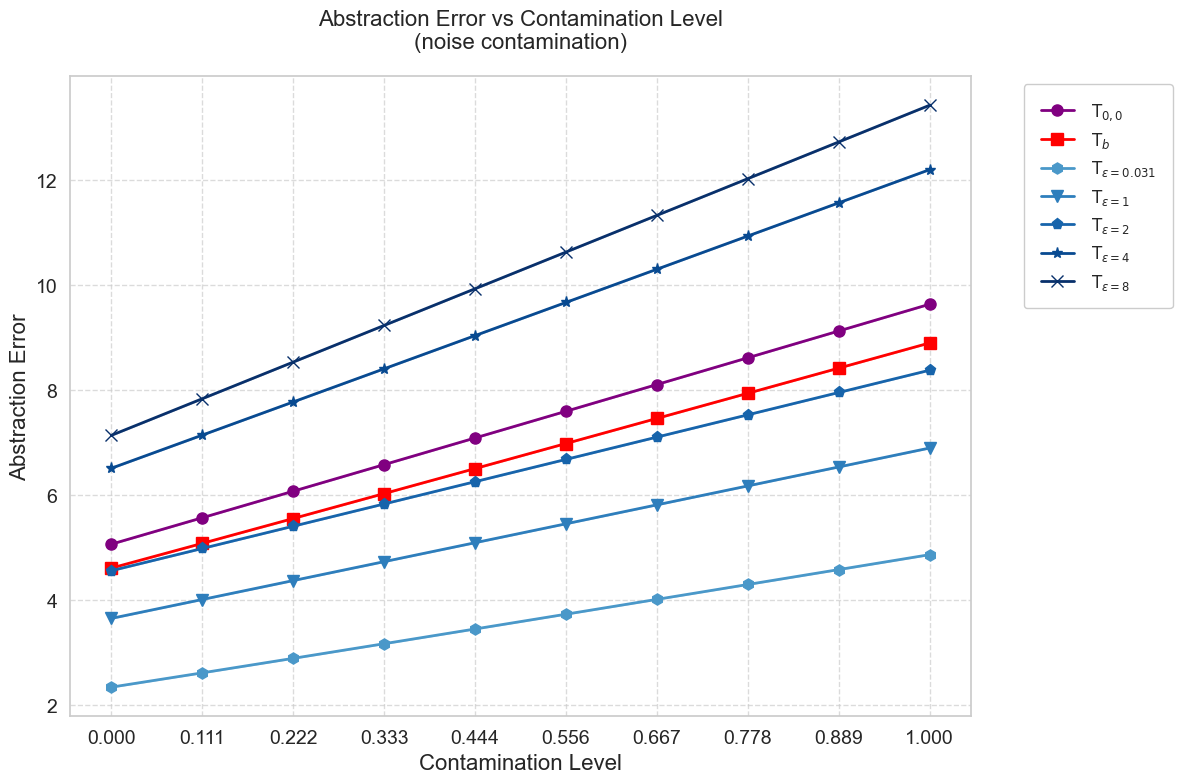

In [115]:
# Define contamination levels to test
contamination_levels = np.linspace(0.0, 1.0, 10)  # [0.1, 0.2, 0.3, 0.4, 0.5]
cont_type = 'nonlinear'

# Store results for plotting
plot_results = {method: {'means': [], 'stds': []} for method in T_results.keys()}


# Run experiment for each contamination level
for cont_frac in tqdm(contamination_levels):
   #print(f"\nTesting contamination fraction: {cont_frac:.2f}")
   abstraction_error = {name: [] for name in T_results.keys()}
  
   for _ in range(5):
       noise_muL, noise_SigmaL = mu_U_ll_hat, Sigma_U_ll_hat
       noise_muH, noise_SigmaH = mu_U_hl_hat, Sigma_U_hl_hat
      
       noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
       noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
       noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
       noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH


       for name, res in T_results.items():
           T = res['T_matrix']
           total = 0
           for iota in Ill:
               L_i = LLmodels[iota].F
               L_i = contaminate_structural_matrix(L_i, contamination_fraction=cont_frac, contamination_type=cont_type)
               V_i = T @ L_i
               H_i = HLmodels[omega[iota]].F
               H_i = contaminate_structural_matrix(H_i, contamination_fraction=cont_frac, contamination_type=cont_type)
              
               muV    = V_i @ noise_muL
               sigmaV = V_i @ noise_SigmaL @ V_i.T
               muH    = H_i @ noise_muH
               sigmaH = H_i @ noise_SigmaH @ H_i.T


               dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
               total += dist


           iter_avg = total / len(Ill)
           abstraction_error[name].append(iter_avg)


   # Store results for this contamination level
   for method in T_results.keys():
       mean_e = np.mean(abstraction_error[method])
       std_e = np.std(abstraction_error[method])
       plot_results[method]['means'].append(mean_e)
       plot_results[method]['stds'].append(std_e)


# Example: plot only three methods
methods_to_plot = ['T_0.00', 'T_b', 'T_0.031', 'T_1', 'T_2', 'T_4', 'T_8']
plot_contamination_results(plot_results, contamination_levels, "noise",
                         methods_to_plot=methods_to_plot)

### For paper

In [112]:
# Define contamination levels to test
contamination_levels = np.linspace(0.0, 10.0, 10)  # [0.1, 0.2, 0.3, 0.4, 0.5]
for cont_type in ['nonlinear', 'piecewise', 'multiplicative']:
    print(f"Contamination type: {cont_type}")
    # Store results for plotting
    plot_results = {method: {'means': [], 'stds': []} for method in T_results.keys()}


    # Run experiment for each contamination level
    for cont_frac in tqdm(contamination_levels):
    #print(f"\nTesting contamination fraction: {cont_frac:.2f}")
        abstraction_error = {name: [] for name in T_results.keys()}
    
        for _ in range(1):
            noise_muL, noise_SigmaL = mu_U_ll_hat, Sigma_U_ll_hat
            noise_muH, noise_SigmaH = mu_U_hl_hat, Sigma_U_hl_hat
            
            noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
            noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
            noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
            noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH


            for name, res in T_results.items():
                T = res['T_matrix']
                total = 0
                for iota in Ill:
                    L_i = LLmodels[iota].F
                    L_i = contaminate_structural_matrix(L_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    V_i = T @ L_i
                    H_i = HLmodels[omega[iota]].F
                    H_i = contaminate_structural_matrix(H_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    
                    muV    = V_i @ noise_muL
                    sigmaV = V_i @ noise_SigmaL @ V_i.T
                    muH    = H_i @ noise_muH
                    sigmaH = H_i @ noise_SigmaH @ H_i.T


                    dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                    # dim = muV.shape[0]  # number of dimensions
                    # dist = dist / np.sqrt(dim)

                    total += dist


                iter_avg = total / len(Ill)
                abstraction_error[name].append(iter_avg)


        # Store results for this contamination level
        for method in T_results.keys():
            mean_e = np.mean(abstraction_error[method])
            std_e = np.std(abstraction_error[method])
            plot_results[method]['means'].append(mean_e)
            plot_results[method]['stds'].append(std_e)

    # Compute averages across all contamination levels for each method
    method_averages = {}

    for method in T_results.keys():
        # Get all means across contamination levels
        all_means = plot_results[method]['means']
        # Compute the mean and std across all contamination levels
        overall_mean = np.mean(all_means)
        overall_std = np.std(all_means)
        method_averages[method] = (overall_mean, overall_std)

    # Sort methods by average (worst to best)
    sorted_methods = sorted(method_averages.items(), key=lambda x: x[1][0], reverse=True)

    # Print results
    print("\n" + "="*100)
    print("AVERAGE WASSERSTEIN DISTANCE ACROSS ALL CONTAMINATION LEVELS (0.0 to 1.0)")
    print("="*100)
    print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
    print("-"*100)

    for method, (mean, std) in sorted_methods:
        ci = 1.96 * std
        print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")

    print("="*100)


Contamination type: nonlinear


100%|██████████| 10/10 [00:00<00:00, 15.11it/s]



AVERAGE WASSERSTEIN DISTANCE ACROSS ALL CONTAMINATION LEVELS (0.0 to 1.0)
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_ba             57.6936 ± 58.7670 
T_s              46.0276 ± 47.0106 
T_8              38.5899 ± 39.3675 
T_4              34.9457 ± 35.5851 
T_0.00           28.0738 ± 28.8364 
T_b              26.2330 ± 27.1082 
T_2              23.6730 ± 23.9234 
T_1              19.8779 ± 20.3040 
T_0.031          15.1560 ± 16.0775 
Contamination type: piecewise


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]



AVERAGE WASSERSTEIN DISTANCE ACROSS ALL CONTAMINATION LEVELS (0.0 to 1.0)
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_b              37.2374 ± 44.8137 
T_0.031          34.5918 ± 41.7708 
T_1              30.8933 ± 34.4830 
T_2              30.8238 ± 34.6142 
T_s              29.8201 ± 29.5132 
T_0.00           29.5550 ± 33.0427 
T_ba             28.6890 ± 27.8857 
T_8              28.1728 ± 27.9895 
T_4              28.0897 ± 30.6202 
Contamination type: multiplicative


100%|██████████| 10/10 [00:00<00:00, 13.42it/s]


AVERAGE WASSERSTEIN DISTANCE ACROSS ALL CONTAMINATION LEVELS (0.0 to 1.0)
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_b              37.1192 ± 42.0900 
T_0.031          35.2474 ± 39.5302 
T_1              33.2636 ± 38.5930 
T_ba             30.9391 ± 29.6788 
T_2              29.8903 ± 36.2528 
T_s              29.7831 ± 31.0662 
T_0.00           29.1759 ± 33.0484 
T_8              29.0008 ± 30.3821 
T_4              28.5218 ± 31.1180 


## ω-contamination

In [118]:
def contaminate_omega_map(original_omega, num_misalignments):
    """
    Randomly corrupt a subset of entries in the ω map to simulate mapping misspecification.
    
    Args:
        original_omega (dict): Original intervention mapping.
            For example: {None: None, iota1: H_i1, iota2: H_i1, iota3: H_i2, ...}
        num_misalignments (int): Desired number of misaligned mappings.
        
    Returns:
        dict: A new ω mapping with up to num_misalignments entries altered.
    """
    # Exclude keys or values that are None if desired.
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]
    
    # Start with a copy of the original mapping.
    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))
    
    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

In [119]:
# Define contamination levels to test
misalignment_levels = range(0, len(Ill))

# Store results for plotting
omega_plot_results = {method: {'means': [], 'stds': []} for method in T_results.keys()}


# Run experiment for each contamination level
for num_mis in tqdm(misalignment_levels):
   abstraction_error = {name: [] for name in T_results.keys()}
  
   for _ in range(10):
    noise_muL, noise_SigmaL = mu_U_ll_hat, Sigma_U_ll_hat
    noise_muH, noise_SigmaH = mu_U_hl_hat, Sigma_U_hl_hat
    
    noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
    noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
    noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
    noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

    omega_cont = contaminate_omega_map(omega, num_mis)


    for name, res in T_results.items():
        T = res['T_matrix']
        total = 0
        for iota in Ill:
            L_i = LLmodels[iota].F
            V_i = T @ L_i
            H_i = HLmodels[omega_cont[iota]].F
            
            muV    = V_i @ noise_muL
            sigmaV = V_i @ noise_SigmaL @ V_i.T
            muH    = H_i @ noise_muH
            sigmaH = H_i @ noise_SigmaH @ H_i.T


            dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
            total += dist


        iter_avg = total / len(Ill)
        abstraction_error[name].append(iter_avg)


   # Store results for this contamination level
   for method in T_results.keys():
       mean_e = np.mean(abstraction_error[method])
       std_e = np.std(abstraction_error[method])
       omega_plot_results[method]['means'].append(mean_e)
       omega_plot_results[method]['stds'].append(std_e)



100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


In [120]:
def plot_omega_contamination_results(omega_plot_results, misalignment_levels, methods_to_plot=None):
    """
    Plot the results of contamination analysis for selected methods.
    
    Args:
        omega_plot_results: Dictionary containing means and stds for each method
        misalignment_levels: Array of misalignment levels tested
        methods_to_plot: List of method names to plot. If None, plots all methods
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(omega_plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: omega_plot_results[method] 
                      for method in methods_to_plot 
                      if method in omega_plot_results}
    
    # Define base method styles
    method_styles = {
        'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
        'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
        'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
        'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
    }
    
    # Add styles for trained T matrices using different markers and blues
    blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
    markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
    for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
        method_name = f'T_{eps}'
        method_styles[method_name] = {
            'color': blues[i],
            'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
            'marker': markers[i]
        }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(misalignment_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=8,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(misalignment_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Number of Misalignments', fontsize=16)
    plt.ylabel('Abstraction Error', fontsize=16)
    plt.title(f'Abstraction Error vs Number of Misalignments',
             fontsize=16, pad=20)
    
    plt.xticks(misalignment_levels, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add legend
    plt.legend(prop={'size': 12},
              frameon=True,
              framealpha=1,
              borderpad=1,
              handletextpad=1,
              handlelength=2,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print ordered results for each misalignment level
    print("\nOrdered results at each misalignment level (worst to best):")
    for i, num_mis in enumerate(misalignment_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        # Sort by error value in descending order (worst to best)
        sorted_methods = sorted(errors.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nNumber of misalignments: {num_mis}")
        print("-" * 40)
        for method, error in sorted_methods:
            print(f"{method:8s}: {error:.4f}")
        print("-" * 40)


Ordered results at each misalignment level (worst to best):

Number of misalignments: 0
----------------------------------------
T_8     : 7.1346
T_4     : 6.5086
T_0.00  : 5.0644
T_b     : 4.6097
T_2     : 4.5597
T_1     : 3.6526
T_0.031 : 2.3452
----------------------------------------

Number of misalignments: 1
----------------------------------------
T_8     : 7.1347
T_4     : 6.5042
T_0.00  : 5.0796
T_b     : 4.6064
T_2     : 4.6025
T_1     : 3.7077
T_0.031 : 2.4136
----------------------------------------

Number of misalignments: 2
----------------------------------------
T_8     : 7.1535
T_4     : 6.5174
T_0.00  : 5.1187
T_2     : 4.6279
T_b     : 4.6126
T_1     : 3.7313
T_0.031 : 2.4404
----------------------------------------

Number of misalignments: 3
----------------------------------------
T_8     : 7.1611
T_4     : 6.5152
T_0.00  : 5.1314
T_2     : 4.6371
T_b     : 4.6098
T_1     : 3.7474
T_0.031 : 2.4562
----------------------------------------

Number of misalignment

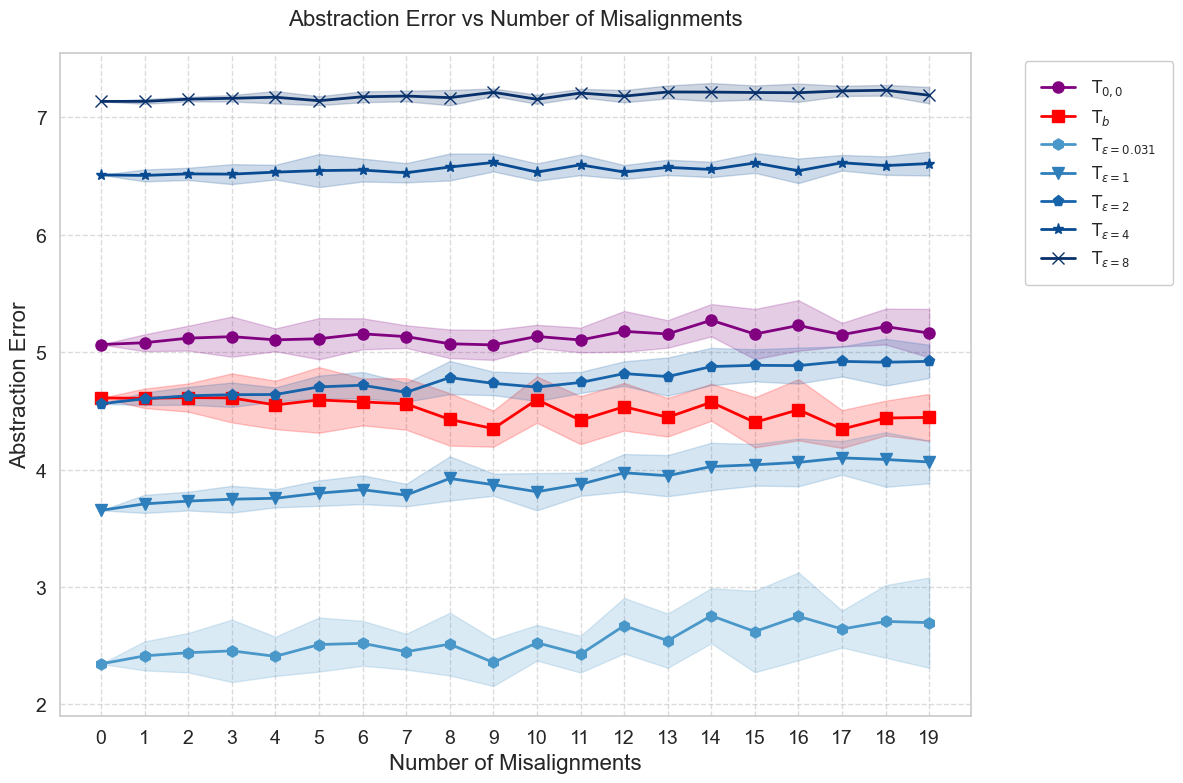

In [121]:
# Example: plot only three methods
methods_to_plot = ['T_0.00', 'T_b', 'T_0.031', 'T_1', 'T_2', 'T_4', 'T_8']
plot_omega_contamination_results(omega_plot_results, misalignment_levels, 
                               methods_to_plot=methods_to_plot)

In [18]:
# Compute and print the overall averages across all misalignment levels
print("\n" + "="*100)
print("AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS")
print("="*100)
print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
print("-"*100)

# Compute averages for each method
method_averages = []
for method in T_results.keys():
    # Get all means across misalignment levels
    all_means = omega_plot_results[method]['means']
    # Compute overall mean and std
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    method_averages.append((method, overall_mean, overall_std))

# Sort methods by mean (worst to best)
method_averages.sort(key=lambda x: x[1], reverse=True)

# Print sorted averages
for method, mean, std in method_averages:
    ci = 1.96 * std
    print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")

print("="*100)


AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_ba             10.7457 ± 0.0861  
T_s               8.4501 ± 0.0759  
T_8               7.1870 ± 0.0658  
T_4               6.5617 ± 0.0699  
T_0.00            5.1332 ± 0.1313  
T_2               4.7515 ± 0.2304  
T_b               4.4950 ± 0.1665  
T_1               3.8855 ± 0.2786  
T_0.031           2.5181 ± 0.2710  
